In [1]:
import xarray as xr
import numpy as np
import pandas as pd

from snobedo.lib.dask_utils import start_cluster, client_ip_and_port
from snobedo.snotel import SnotelLocations, CsvParser

from common import SHARED_STORE, SNOBAL_DIR, SNOTEL_DIR, DATA_DIR, COARSEN_OPTS, HV_PLOT_OPTS

In [2]:
client = start_cluster(8, 24)
client_ip_and_port(client)

10.242.76.196:8787


In [3]:
year = 2022
water_year = f'wy{year}'

## SNOTEL 

In [4]:
snotel_sites = SnotelLocations()
snotel_sites.load_from_json(SNOTEL_DIR / 'site-locations/snotel_sites.json')

## Model with SMRF clouds and solar 

In [5]:
smrf_eb = xr.open_mfdataset(
    f'{SHARED_STORE}/erw_isnobal/{water_year}/erw/run*/smrf_energy*.nc',
    parallel=True, chunks={'time': 24}, #, 'y' :10, 'x': 10},
)

butte_snobal = smrf_eb.net_solar.sel(x=snotel_sites.Butte.lon, y=snotel_sites.Butte.lat, method='nearest').squeeze(['x', 'y']).compute()
schofield_snobal = smrf_eb.net_solar.sel(x=snotel_sites.Schofield.lon, y=snotel_sites.Schofield.lat, method='nearest').squeeze(['x', 'y']).compute()
taylor_snobal = smrf_eb.net_solar.sel(x=snotel_sites.Taylor.lon, y=snotel_sites.Taylor.lat, method='nearest').squeeze(['x', 'y']).compute()
irwin_snobal = smrf_eb.net_solar.sel(x=snotel_sites.Irwin.lon, y=snotel_sites.Irwin.lat, method='nearest').squeeze(['x', 'y']).compute()

irwin_snobal_a_ir = smrf_eb.albedo_ir.sel(x=snotel_sites.Irwin.lon, y=snotel_sites.Irwin.lat, method='nearest').squeeze(['x', 'y']).compute()
irwin_snobal_a_vis = smrf_eb.albedo_vis.sel(x=snotel_sites.Irwin.lon, y=snotel_sites.Irwin.lat, method='nearest').squeeze(['x', 'y']).compute()
irwin_snobal_albedo = (0.67*irwin_snobal_a_vis)+(0.33*irwin_snobal_a_ir)

del smrf_eb

## Model run with HRRR clouds and solar

In [6]:
HRRR_solar = xr.open_mfdataset(
    f'{SHARED_STORE}/erw_isnobal/{water_year}/erw_hrrr_solar/run*/net_solar.nc',
    parallel=True, chunks={'time': 24}, # 'y' :10, 'x': 10},
    drop_variables=['DSWRF', 'illumination_angle', 'zenith', 'azimuth', 'albedo_vis', 'albedo_ir'],
)

butte_snobal_hrrr = HRRR_solar.net_solar.sel(x=snotel_sites.Butte.lon, y=snotel_sites.Butte.lat, method='nearest').squeeze(['x', 'y']).compute()
schofield_snobal_hrrr = HRRR_solar.net_solar.sel(x=snotel_sites.Schofield.lon, y=snotel_sites.Schofield.lat, method='nearest').squeeze(['x', 'y']).compute()
taylor_snobal_hrrr = HRRR_solar.net_solar.sel(x=snotel_sites.Taylor.lon, y=snotel_sites.Taylor.lat, method='nearest').squeeze(['x', 'y']).compute()
irwin_snobal_hrrr = HRRR_solar.net_solar.sel(x=snotel_sites.Irwin.lon, y=snotel_sites.Irwin.lat, method='nearest').squeeze(['x', 'y']).compute()

## Model run with HRRR clouds and solar + MODIS albedo

In [7]:
HRRR_solar = xr.open_mfdataset(
    f'{SHARED_STORE}/erw_isnobal/{water_year}/erw_hrrr_solar_modis_cubic/run*/net_solar.nc',
    parallel=True, chunks={'time': 24}, # 'y' :10, 'x': 10},
    drop_variables=['DSWRF', 'illumination_angle'],
)

butte_snobal_hrrr_modis = HRRR_solar.net_solar.sel(x=snotel_sites.Butte.lon, y=snotel_sites.Butte.lat, method='nearest').squeeze(['x', 'y']).compute()
schofield_snobal_hrrr_modis = HRRR_solar.net_solar.sel(x=snotel_sites.Schofield.lon, y=snotel_sites.Schofield.lat, method='nearest').squeeze(['x', 'y']).compute()
taylor_snobal_hrrr_modis = HRRR_solar.net_solar.sel(x=snotel_sites.Taylor.lon, y=snotel_sites.Taylor.lat, method='nearest').squeeze(['x', 'y']).compute()
irwin_snobal_hrrr_modis = HRRR_solar.net_solar.sel(x=snotel_sites.Irwin.lon, y=snotel_sites.Irwin.lat, method='nearest').squeeze(['x', 'y']).compute()
irwin_snobal_hrrr_modis_albedo = HRRR_solar.albedo.sel(x=snotel_sites.Irwin.lon, y=snotel_sites.Irwin.lat, method='nearest').squeeze(['x', 'y']).compute()/10000

del HRRR_solar

## Irwin (Recorded in UTC)

In [8]:
PD_OPTS = dict(
    parse_dates=True,
    index_col=0,
    names=['Temp', 'VIS_IN', 'NIR_IN', 'VIS_OUT', 'NIR_OUT'],
    header=0,
)

irwin_pyra = pd.concat([
    pd.read_csv(DATA_DIR / 'Snotel/wy2021/Irwin/2021-Irwin.csv', **PD_OPTS),
    pd.read_csv(DATA_DIR / 'Snotel/wy2022/Irwin/2022-Irwin.csv', **PD_OPTS),
])

irwin_pyra = irwin_pyra.fillna({'VIS_IN': 0}).astype(np.float64)

### Filter unrealistic values

In [9]:
irwin_pyra[irwin_pyra < 0] = 0
## Max possible incoming from the sun
irwin_pyra[irwin_pyra > 1300] = 1300
## no OUTCOMING when there is no INCOMING
irwin_pyra.loc[irwin_pyra['VIS_IN'] <= 0, 'VIS_OUT'] = 0
irwin_pyra.loc[irwin_pyra['NIR_IN'] <= 0, 'NIR_OUT'] = 0
## no OUTCOMING larger than INCOMING
irwin_pyra['VIS_OUT'] = irwin_pyra.apply(lambda r: r['VIS_OUT'] if r['VIS_OUT'] < r['VIS_IN'] else r['VIS_IN'], axis=1)
irwin_pyra['NIR_OUT'] = irwin_pyra.apply(lambda r: r['NIR_OUT'] if r['NIR_OUT'] < r['NIR_IN'] else r['NIR_IN'], axis=1)

### Reduce measurement spikes
Data is measured every 15 mins, averages 8 hours at a time to reduce spikes in data

In [10]:
ROLL_WINDOW=32 

### Calculate variables of interest 

In [11]:
irwin_pyra['net_solar'] = (
    irwin_pyra['VIS_IN'] + irwin_pyra['NIR_IN'] - irwin_pyra['VIS_OUT'] - irwin_pyra['NIR_OUT']
).rolling(ROLL_WINDOW).mean().interpolate('time')

irwin_pyra['albedo'] = (
    (0.67 * (irwin_pyra['VIS_OUT'] / irwin_pyra['VIS_IN'])) + (0.33 * (irwin_pyra['NIR_OUT'] / irwin_pyra['NIR_IN']))
).rolling(ROLL_WINDOW).mean().interpolate('time')

#### No albedo value higher than 0.94 should be present

In [12]:
irwin_pyra.loc[irwin_pyra['albedo'] >= 0.94, 'albedo'] = 0.94

In [13]:
irwin_pyra['solar'] = (irwin_pyra['net_solar'] / (1 - irwin_pyra['albedo']))

### Filter to 11 AM MST - MODIS overpass

In [14]:
irwin_MODIS = irwin_pyra.at_time('18:00')

# Net Solar

In [15]:
STATION_LABEL = 'Station'

COLORS = {
        'HRRR-MODIS': 'cornflowerblue',
        'HRRR-SC': 'lightcoral',
        'Time-Decay': 'sandybrown',
        STATION_LABEL: 'seagreen',    
}

In [16]:
SNOW_GONE = {
    '2021': {
        'Butte': {
            STATION_LABEL:np.datetime64('2021-05-12'),
            'HRRR-MODIS': np.datetime64('2021-05-13'),
            'HRRR-SC': np.datetime64('2021-05-15'),
            'Time-Decay': np.datetime64('2021-05-30'),
        },
        'Schofield Pass': {
            STATION_LABEL: np.datetime64('2021-06-02'),
            'HRRR-MODIS': np.datetime64('2021-06-07'),
            'HRRR-SC': np.datetime64('2021-06-04'),
            'Time-Decay': np.datetime64('2021-06-17'),
        },
        'Irwin Study Plot': {
            STATION_LABEL: np.datetime64('2021-06-01'),
        }
    },
    '2022': {
        'Butte': {
            STATION_LABEL:np.datetime64('2022-05-08'),
            'HRRR-MODIS': np.datetime64('2022-05-14'),
            'HRRR-SC': np.datetime64('2022-05-16'),
            'Time-Decay': np.datetime64('2022-06-02'),
        },
        'Schofield Pass': {
            STATION_LABEL: np.datetime64('2022-06-04'),
            'HRRR-MODIS': np.datetime64('2022-06-09'),
            'HRRR-SC': np.datetime64('2022-06-16'),
            'Time-Decay': np.datetime64('2022-07-07'),
        },
        'Irwin Study Plot': {
            STATION_LABEL: np.datetime64('2022-06-01'),
            'HRRR-MODIS': np.datetime64('2022-07-08'),
            'HRRR-SC': np.datetime64('2022-06-05'),
            'Time-Decay': np.datetime64('2022-06-05'),        
        }
    }
}

SNOW_ONSET = {
    '2021': { 
        'Butte': np.datetime64('2020-10-25'),
        'Schofield Pass': np.datetime64('2020-10-25'),
        'Irwin Study Plot': np.datetime64('2020-10-25'),
    },
    '2022': {
        'Butte': np.datetime64('2021-11-01'),
        'Schofield Pass': np.datetime64('2021-10-08'),
        'Irwin Study Plot': np.datetime64('2021-10-11'),
    }
}
    

In [17]:
def with_snow_at_site(site_name, data):
    return data[data.time.dt.hour == 18].where(
        data.time >= SNOW_ONSET[str(year)][site_name]
    ).where(
        data.time <= SNOW_GONE[str(year)][site_name][STATION_LABEL]
    )

In [18]:
def df_with_snow_at_site(site_name, df):
    return df[
        (df.index >= SNOW_ONSET[str(year)][site_name]) & \
        (df.index <= SNOW_GONE[str(year)][site_name][STATION_LABEL])
    ]

## Matplotlib 

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from matplotlib.offsetbox import AnchoredText
from matplotlib.lines import Line2D

In [20]:
def plot_site(data, ax, site_name, y_limit, add_label=False, add_mean=True):
    print(site_name)
    
    if add_mean:
        mean_ax = ax.twinx()
    else:
        mean_ax = None
    
    for key in data: 
        values = np.nan_to_num(data[key].data.flatten(), copy=False)
        
        mean = np.nanmean(values)
        print(f'  {key} Mean: {mean:.2f}')
            
        if add_mean:
            mean_ax.axhline(
                mean, 
                ls=(0, (1, 1)), lw=1, 
                color=COLORS[key], alpha=0.9, 
            )

        ax.plot(
            data[key].time,
            values,
            label=key, 
            color=COLORS[key], 
            alpha=0.9, lw=1
        )

    if add_mean:
        ax.plot([], [], color='dimgrey', ls=(0, (1, 1)), lw=1, label='Season Means')
    
    ax.set_ylabel(r'Net Solar ($W/m^2$)')

    ax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False)

    ax.set_xlim([plot_range[0], SNOW_GONE[str(year)][site_name][STATION_LABEL]])
    ax.set_yticks(np.arange(0, y_limit +1, 50))
    ax.set_ylim(bottom=-0.1, top=y_limit)
    ax.yaxis.set_minor_locator(mticker.MultipleLocator(10))
    
    if add_mean:
        mean_max = 100 if year == 2021 else 140
        mean_ax.set_ylim(bottom=0, top=mean_max)
        mean_ax.set_ylabel(r'Mean Net Solar ($W/m^2$)')
    
    if add_label:
        site_label(site_name, ax)
        
    return mean_ax

def site_label(site_name, ax):
    at = AnchoredText(
        site_name, 
        prop=dict(size=10), 
        frameon=True, 
        loc='upper left', 
        pad=0.3, 
        borderpad=0.25,
    )
    at.patch.set_boxstyle("round", pad=0., rounding_size=0.2)
    at.patch.set(edgecolor='lightgrey')
    ax.add_artist(at)

def subplot_letter(letter, axes):
    at = AnchoredText(
        f"{letter})", 
        prop=dict(size=12), 
        frameon=False, 
        loc='upper left', 
        pad=-0.1, 
    )
    axes.add_artist(at)    
    
def style_axes(axes):
    axes.xaxis.set_major_locator(mdates.MonthLocator())
    axes.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
    axes.xaxis.set_major_formatter(mticker.NullFormatter())
    axes.xaxis.set_minor_formatter(xTicks)
    axes.tick_params(axis='x', which='minor', pad=-0.5)

def set_title(axes):
    axes.add_artist(
        AnchoredText(
            f'Water Year {year}', 
            prop=dict(size=10), 
            frameon=False, 
            loc='upper center', 
            pad=0.3, 
            borderpad=0.25,
        )
    )

In [21]:
plot_range = pd.date_range(start=SNOW_ONSET[str(year)]['Schofield Pass'], periods=10, freq='MS')
xTicks = mdates.DateFormatter('%b')

## Incoming Solar 

In [22]:
irwin_snobal_hrrr_modis_solar = irwin_snobal_hrrr_modis / (1 - irwin_snobal_hrrr_modis_albedo)
irwin_snobal_hrrr_solar = irwin_snobal_hrrr / (1 - irwin_snobal_albedo)
irwin_snobal_solar = irwin_snobal / (1 - irwin_snobal_albedo)

Irwin Study Plot
  HRRR-SC Mean: 357.41
  Station Mean: 258.30


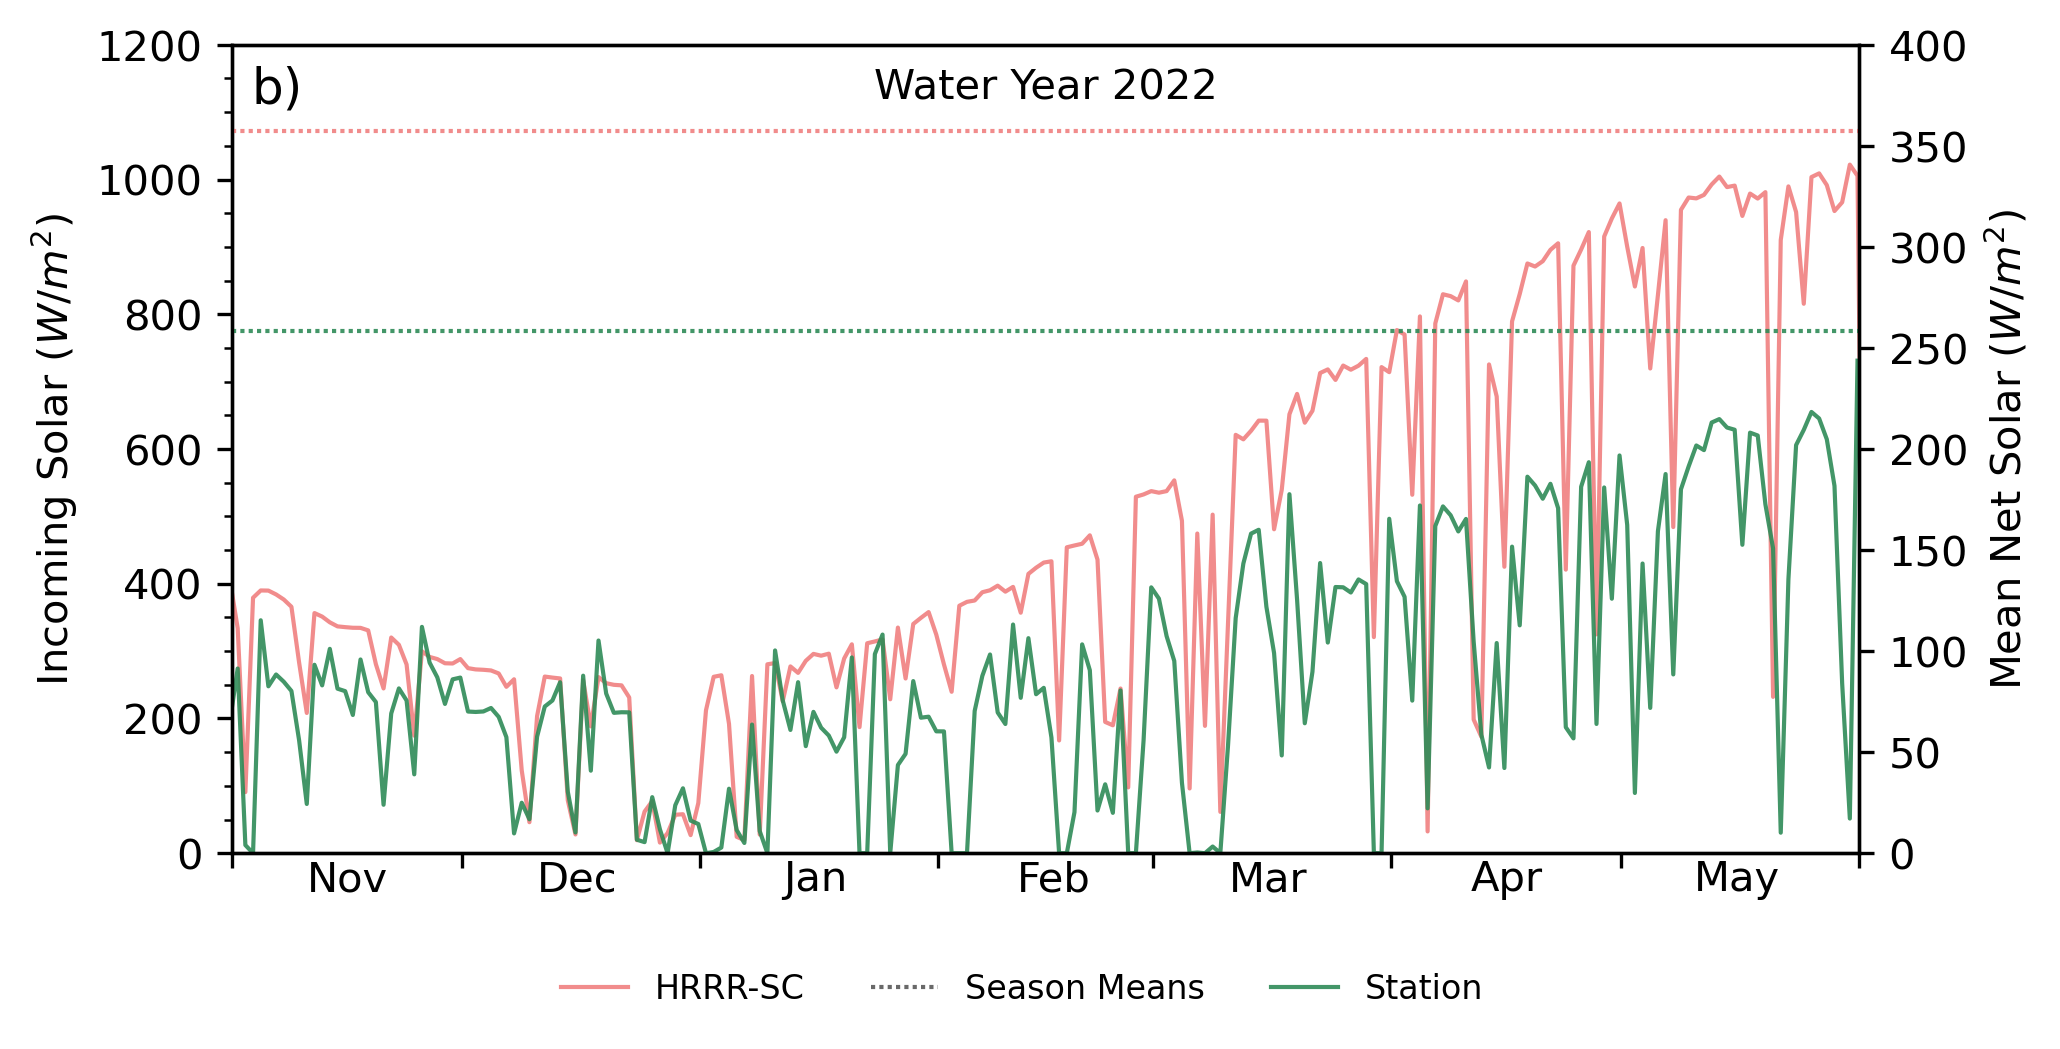

In [23]:
figure_opts = dict(figsize=(7,3.5), dpi=300,)
fig, axes = plt.subplots(1, 1, sharex=True, **figure_opts)

MAX_SUN = 1200

mean_ax = plot_site(
    {
        'HRRR-SC': with_snow_at_site('Irwin Study Plot', irwin_snobal_hrrr_solar),
        # 'Time-Decay': with_snow_at_site('Irwin Study Plot', irwin_snobal_solar),
    },
    axes,
    'Irwin Study Plot',
    MAX_SUN,
    add_mean=True
)

irwin_snow = df_with_snow_at_site('Irwin Study Plot', irwin_MODIS)

axes.plot(
    irwin_snow.index,
    irwin_snow['solar'],
    label=STATION_LABEL, 
    color=COLORS[STATION_LABEL], 
    alpha=0.9, lw=1
)
mean_ax.axhline(
    irwin_snow['solar'].mean(), 
    ls=(0, (1, 1)), lw=1, 
    color=COLORS[STATION_LABEL], alpha=0.9, 
)
mean_ax.set_ylim(bottom=0, top=400)

print(f"  Station Mean: {irwin_snow['solar'].mean():.2f}")

axes.set_ylabel(r'Incoming Solar ($W/m^2$)')

axes.set_yticks(np.arange(0, MAX_SUN + 1, 200))
axes.yaxis.set_minor_locator(mticker.MultipleLocator(50))

style_axes(axes)
set_title(axes)
axes.legend(
    frameon=False,
    bbox_to_anchor=(0.78, -0.125),
    ncol=3,
    borderaxespad=0.15, 
    fontsize=8
)
subplot_letter(('a' if year == 2021 else 'b'), axes)

## Albedo 

  HRRR-MODIS Mean: 0.63
  Time-Decay Mean: 0.62
  Station Mean: 0.70


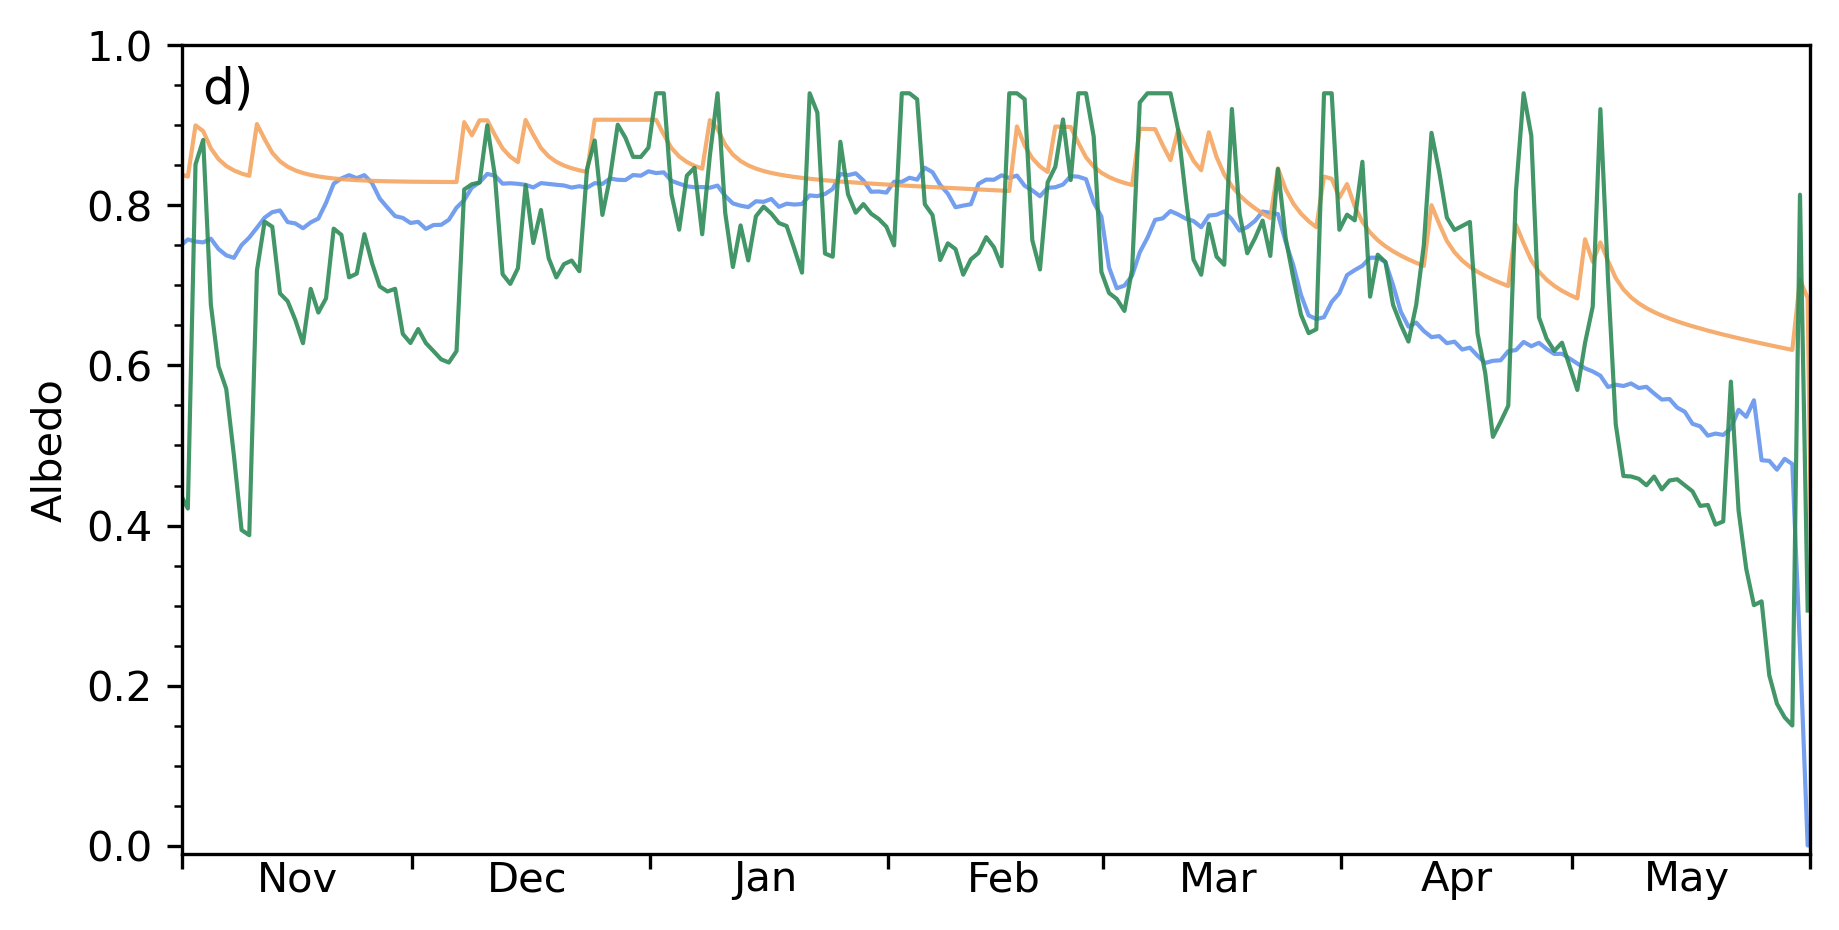

In [24]:
figure_opts = dict(figsize=(7,3.5), dpi=300,)
fig, ax = plt.subplots(1, 1, sharex=True, **figure_opts)

MAX_NS = 1

site_name = 'Irwin Study Plot'
sites = {
    'HRRR-MODIS': with_snow_at_site('Irwin Study Plot', irwin_snobal_hrrr_modis_albedo),
    'Time-Decay': with_snow_at_site('Irwin Study Plot', irwin_snobal_albedo),
}

for key in sites:
    values = np.nan_to_num(sites[key].data.flatten(), copy=False)
    ax.plot(
        sites[key].time,
        values,
        label=key, 
        color=COLORS[key], 
        alpha=0.9, lw=1
    )
    print(f'  {key} Mean: {np.nanmean(values):.2f}')


irwin_snow = df_with_snow_at_site('Irwin Study Plot', irwin_MODIS)
ax.plot(
    irwin_snow.index,
    irwin_snow['albedo'],
    label=STATION_LABEL, 
    color=COLORS[STATION_LABEL], 
    alpha=0.9, lw=1
)
print(f"  Station Mean: {irwin_snow['albedo'].mean():.2f}")

ax.set_ylabel(r'Albedo')

ax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False)

ax.set_xlim([plot_range[0], SNOW_GONE[str(year)][site_name][STATION_LABEL]])

ax.set_yticks(np.arange(0, 1.05, .2))
ax.yaxis.set_minor_locator(mticker.MultipleLocator(0.05))
ax.set_ylim(bottom=-0.01, top=1)

style_axes(ax)
subplot_letter(('c' if year == 2021 else 'd'), ax)

## Net Solar 

Butte
  HRRR-MODIS Mean: 57.66
  HRRR-SC Mean: 49.20
  Time-Decay Mean: 34.38
Schofield Pass
  HRRR-MODIS Mean: 120.15
  HRRR-SC Mean: 82.97
  Time-Decay Mean: 57.63


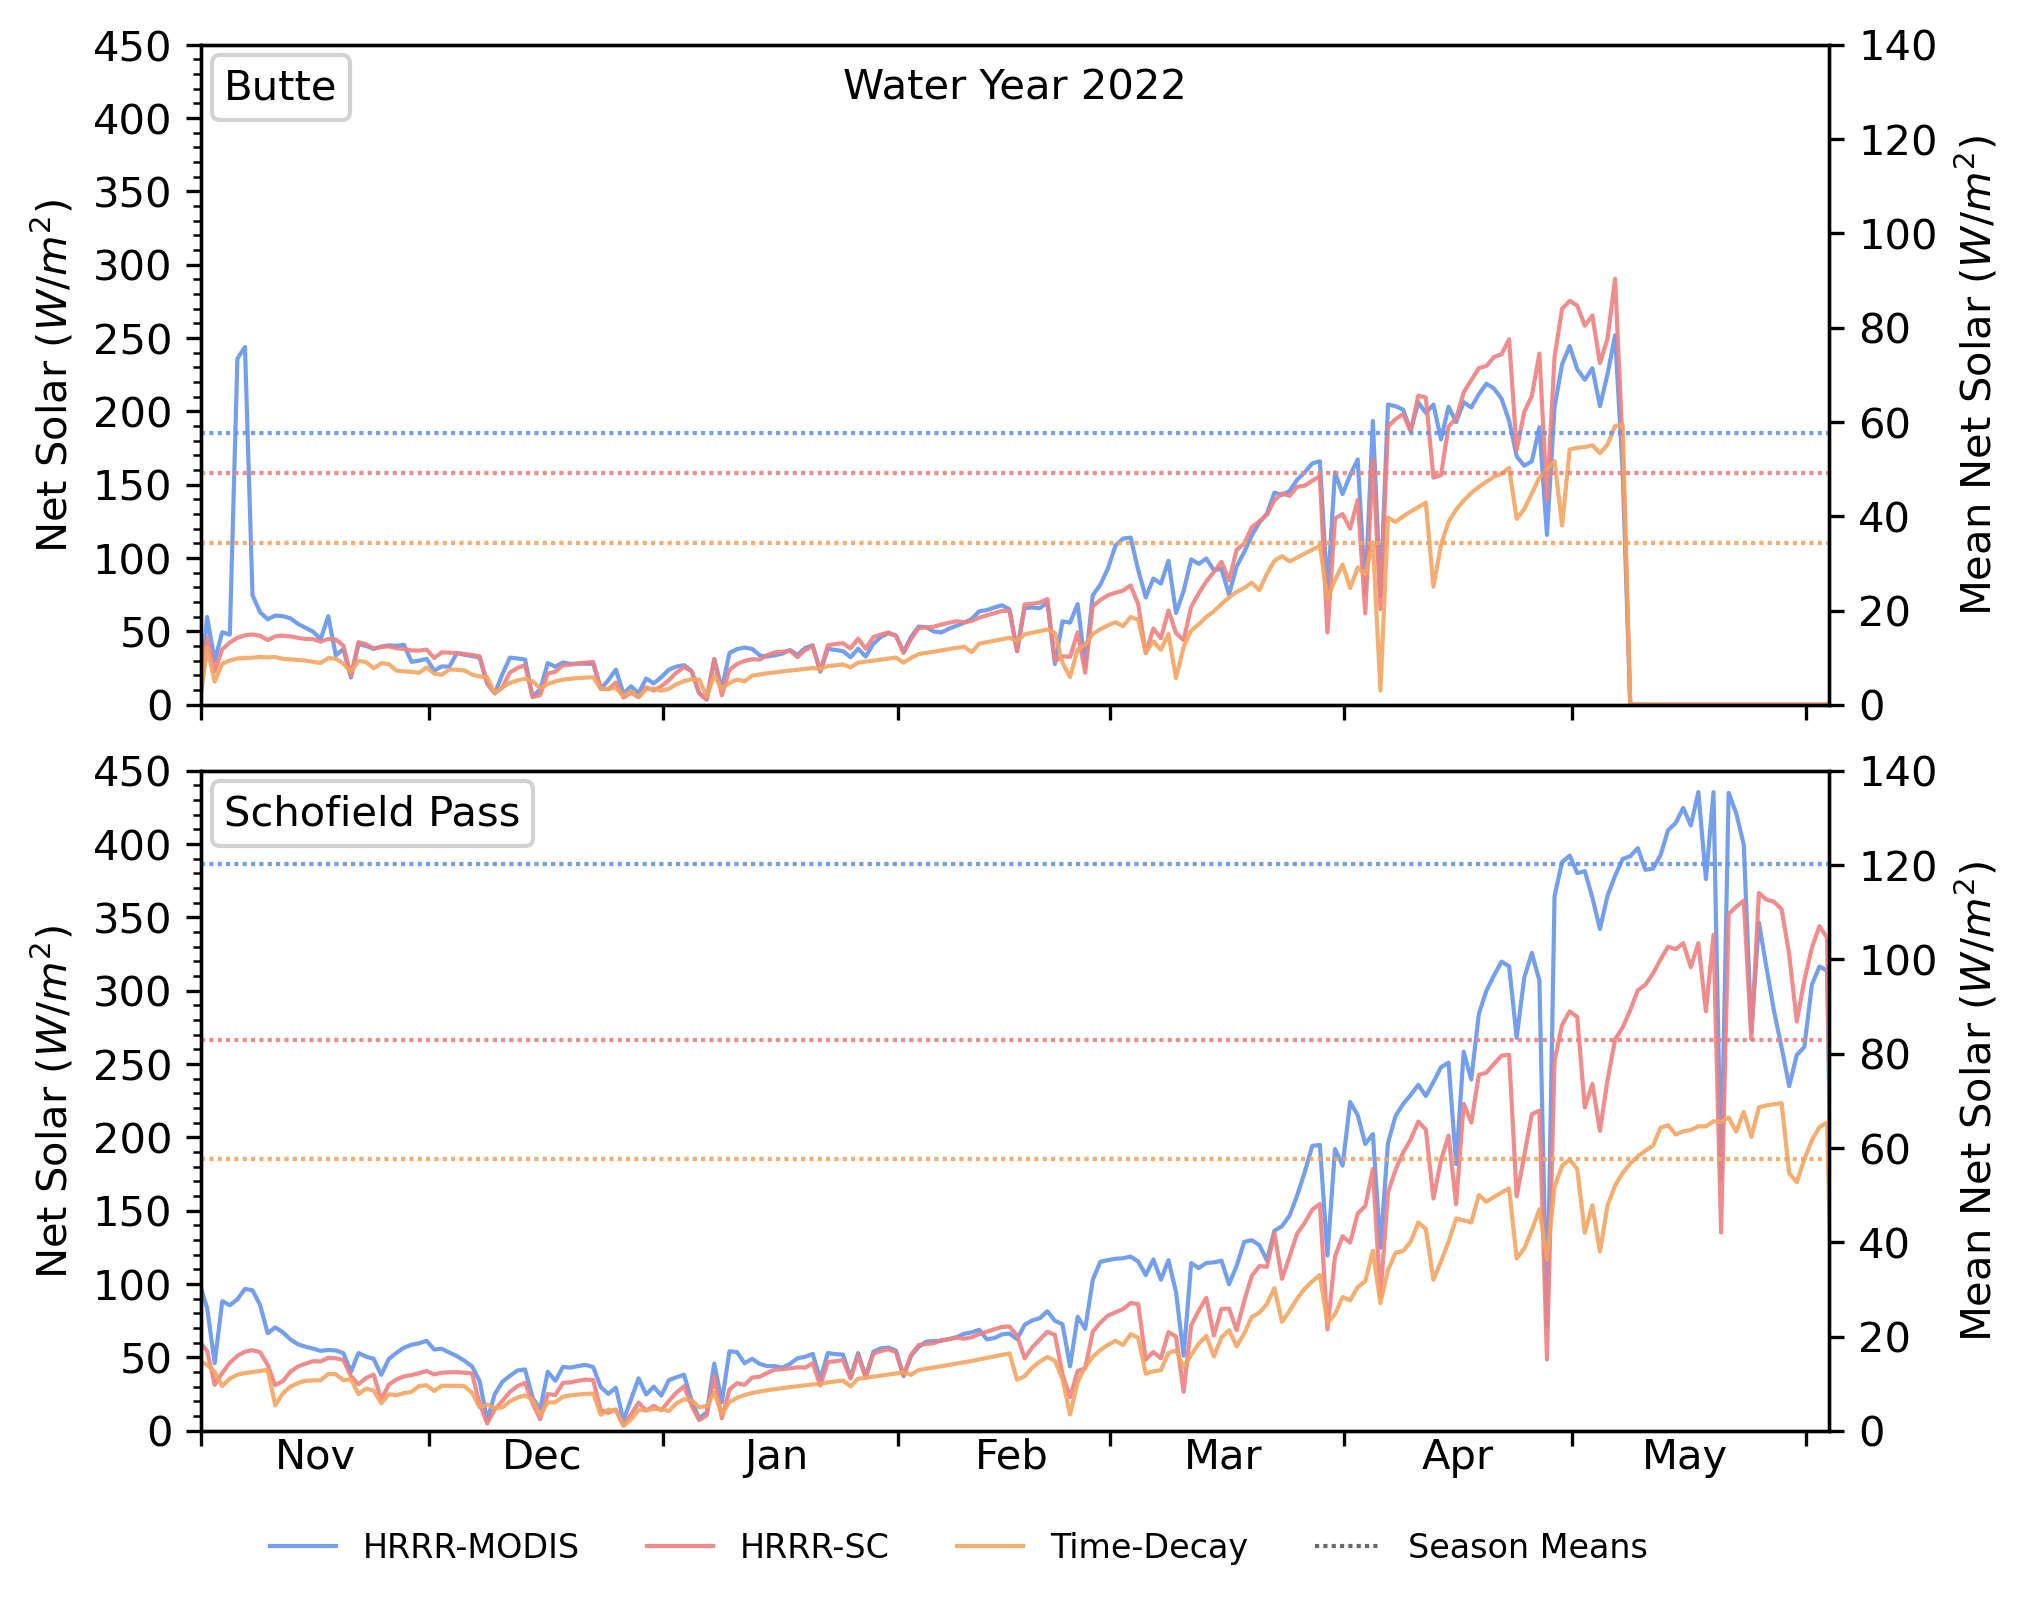

In [25]:
figure_opts = dict(figsize=(7,6), dpi=300,)

fig, axes = plt.subplots(2, 1, sharex=True, **figure_opts)
plt.subplots_adjust(hspace=0.1)

MAX_NS = 400 if year == 2021 else 450

plot_site(
    {
        'HRRR-MODIS': with_snow_at_site('Butte', butte_snobal_hrrr_modis),
        'HRRR-SC': with_snow_at_site('Butte', butte_snobal_hrrr),
        'Time-Decay': with_snow_at_site('Butte', butte_snobal),
    },
    axes[0],
    'Butte',
    MAX_NS,
    True
)

plot_site(
    {
        'HRRR-MODIS': with_snow_at_site('Schofield Pass', schofield_snobal_hrrr_modis),
        'HRRR-SC': with_snow_at_site('Schofield Pass', schofield_snobal_hrrr),
        'Time-Decay': with_snow_at_site('Schofield Pass', schofield_snobal),
    },
    axes[1],
    'Schofield Pass',
    MAX_NS,
    True
)

style_axes(axes[1])
axes[1].legend(
    frameon=False,
    bbox_to_anchor=(0.9, -0.125),
    ncol=4,
    borderaxespad=0.15, 
    fontsize=8
)
set_title(axes[0])

Irwin Study Plot
  HRRR-MODIS Mean: 126.41
  HRRR-SC Mean: 80.10
  Station Mean: 99.36


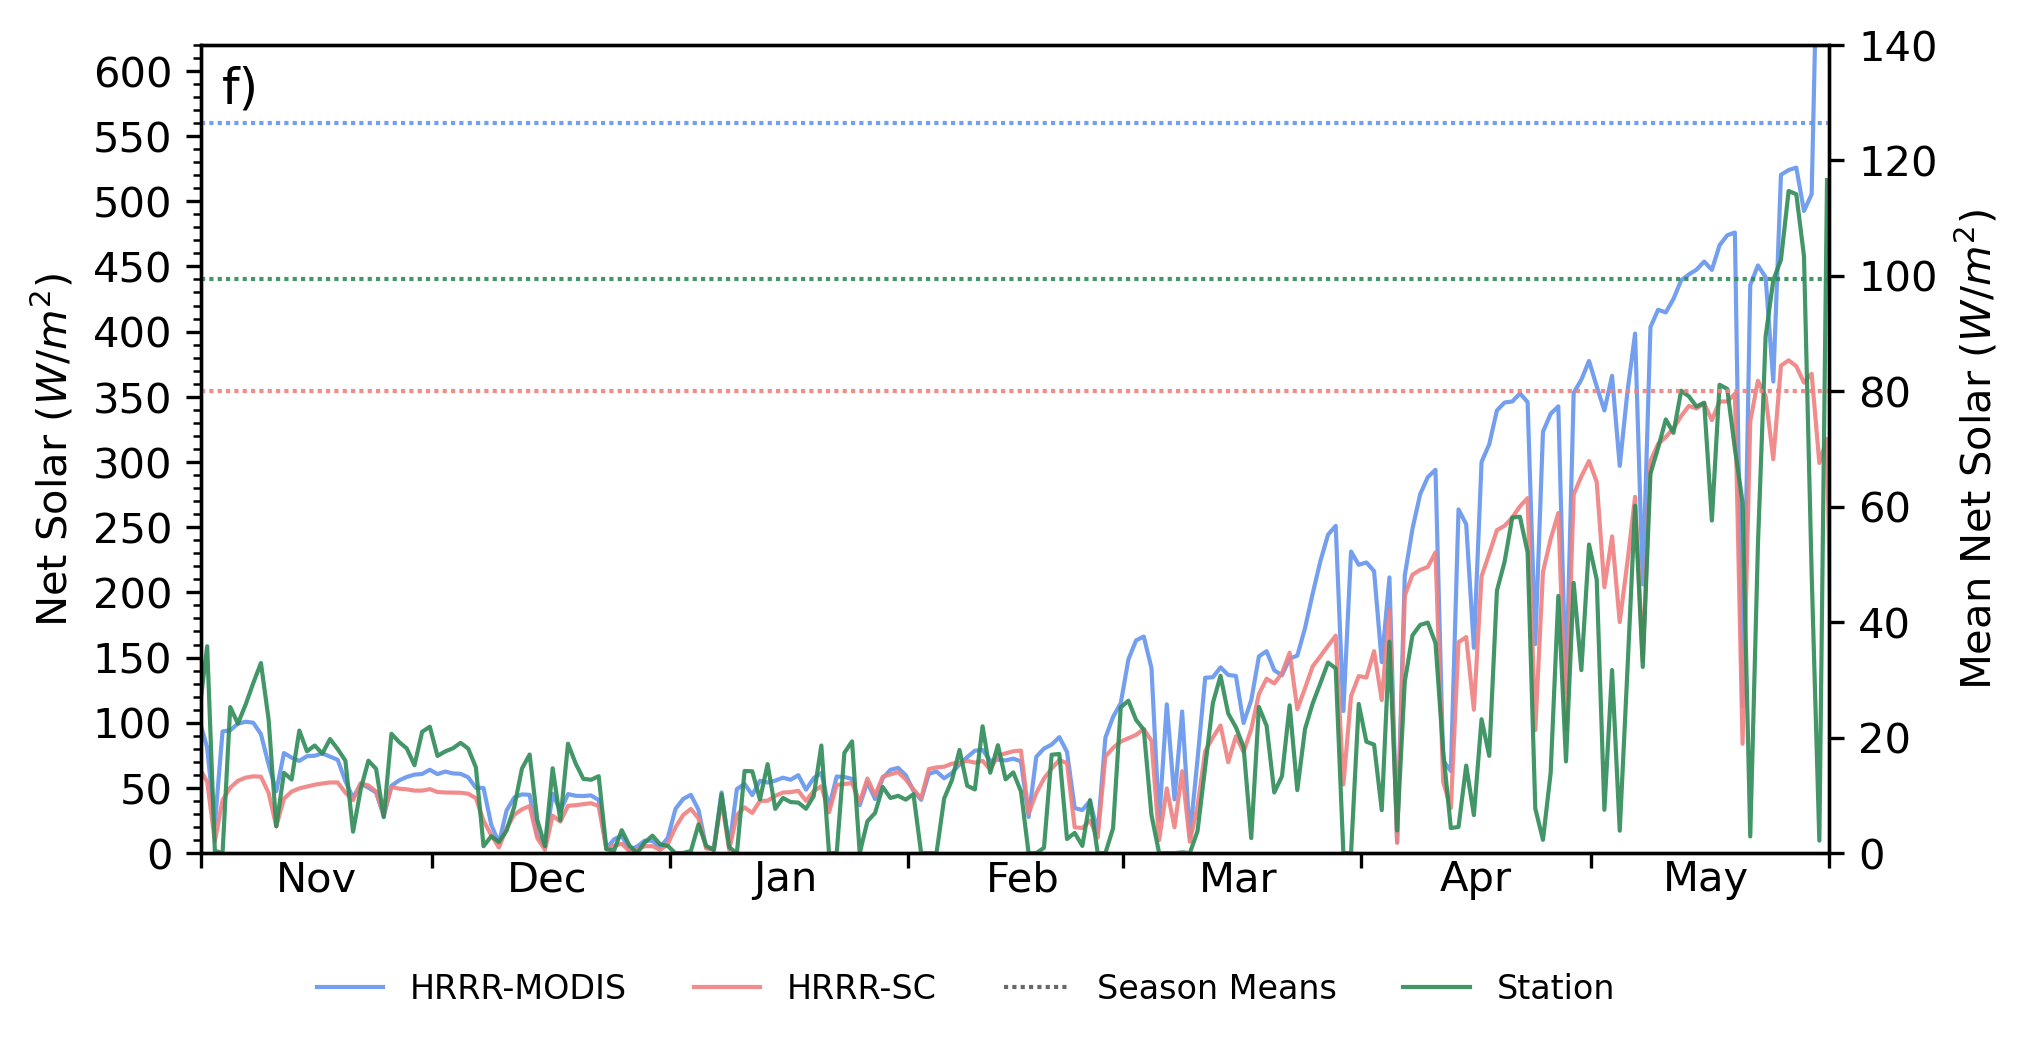

In [26]:
figure_opts = dict(figsize=(7,3.5), dpi=300,)
fig, axes = plt.subplots(1, 1, sharex=True, **figure_opts)

MAX_NS = 640 if year == 2021 else 620

mean_ax = plot_site(
    {
        'HRRR-MODIS': with_snow_at_site('Irwin Study Plot', irwin_snobal_hrrr_modis),
        'HRRR-SC': with_snow_at_site('Irwin Study Plot', irwin_snobal_hrrr),
        # 'Time-Decay': with_snow_at_site('Irwin Study Plot', irwin_snobal),
    },
    axes,
    'Irwin Study Plot',
    MAX_NS,
    add_mean=True,
)

irwin_snow = df_with_snow_at_site('Irwin Study Plot', irwin_MODIS)

axes.plot(
    irwin_snow.index,
    irwin_snow['net_solar'],
    label=STATION_LABEL, 
    color=COLORS[STATION_LABEL], 
    alpha=0.9, lw=1
)
mean_ax.axhline(
    irwin_snow['net_solar'].mean(), 
    ls=(0, (1, 1)), lw=1, 
    color=COLORS[STATION_LABEL], alpha=0.9, 
)
mean_ax.set_ylim(bottom=0, top=140)

print(f"  Station Mean: {irwin_snow['net_solar'].mean():.2f}")

style_axes(axes)
axes.legend(
    frameon=False,
    bbox_to_anchor=(0.88, -0.125),
    ncol=4,
    borderaxespad=0.15, 
    fontsize=8
)
subplot_letter(('e' if year == 2021 else 'f'), axes)

## Differences 

In [27]:
hrrr_modis_diff = irwin_snobal_hrrr_modis[irwin_snobal_hrrr_modis.time.dt.hour == 18].to_pandas() - irwin_MODIS['net_solar']
hrrr_sc_diff = irwin_snobal_hrrr[irwin_snobal_hrrr.time.dt.hour == 18].to_pandas() - irwin_MODIS['net_solar']
time_decay_diff = irwin_snobal[irwin_snobal_hrrr.time.dt.hour == 18].to_pandas() - irwin_MODIS['net_solar']

data = {
    'HRRR-MODIS': df_with_snow_at_site('Irwin Study Plot', hrrr_modis_diff),
    'HRRR-SC': df_with_snow_at_site('Irwin Study Plot', hrrr_sc_diff),
    # 'Time-Decay': df_with_snow_at_site('Irwin Study Plot', time_decay_diff),
}

Median diff with measured snow
  HRRR-MODIS: 32.31
  HRRR-SC: 28.45
Irwin Study Plot


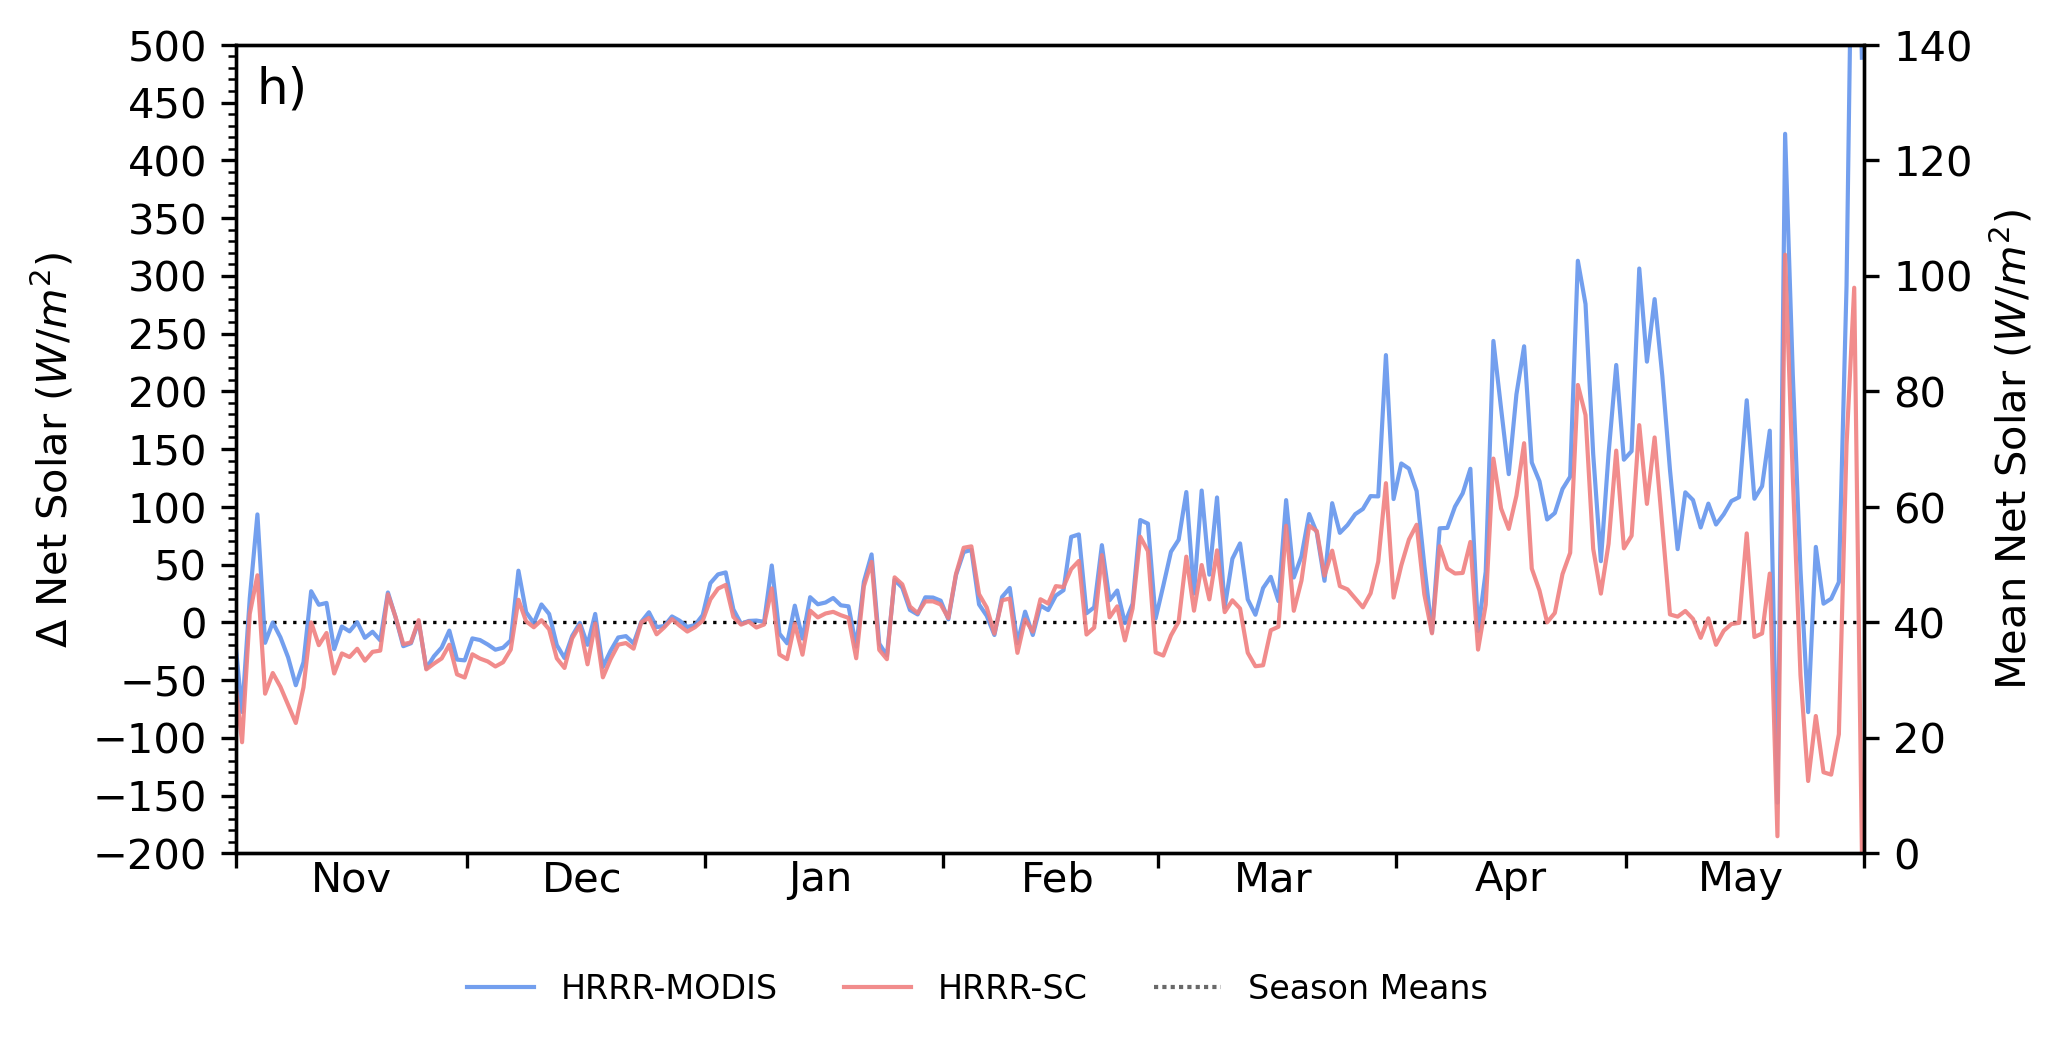

In [28]:
figure_opts = dict(figsize=(7,3.5), dpi=300,)
fig, axes = plt.subplots(1, 1, sharex=True, **figure_opts)

print('Median diff with measured snow')

for key in data:

    print(f"  {key}: {data[key].abs().median():.2f}")
    axes.plot(
        data[key].index,
        data[key],
        label=key, 
        color=COLORS[key], 
        alpha=0.9, lw=1
    )

plot_site(
    {},
    axes,
    'Irwin Study Plot',
    600
)

style_axes(axes)
axes.legend(
    frameon=False,
    bbox_to_anchor=(0.78, -0.125),
    ncol=3,
    borderaxespad=0.15, 
    fontsize=8
)
axes.set_ylabel(r'Δ Net Solar ($W/m^2$)')
axes.set_ylim(bottom=-200, top=500)
axes.set_yticks(np.arange(-200, 500+1, 50))
axes.axhline(0, lw=0.8, ls=(1, (1, 2)), color='black', zorder=0, alpha=1)

subplot_letter(('g' if year == 2021 else 'h'), axes)

## Holoviews

In [29]:
import hvplot.xarray
import hvplot.pandas
import holoviews as hv

pd.options.plotting.backend = 'holoviews'

In [30]:
HV_PLOT_OPTS = dict(
    width=1200, 
    height=800,
    ylabel='Net Solar (W/m^2)',
    xlabel='Water Year 2022',
)

LINE_WIDTH = 2

x_lim = (np.datetime64(f'{year-1}-10-01'), np.datetime64(f'{year}-06-01'))

Fix pandas 0.14.6 error for time series with no name
Error message: `DataError: Having a non-string as a column name in a DataFrame is not supported.`

In [31]:
hrrr_modis_diff.name = 'HRRR MODIS Difference'
hrrr_sc_diff.name = 'HRRR-SC Difference'
time_decay_diff.name = 'Time-Decay Difference'

In [32]:
hrrr_modis_diff.hvplot(label='HRRR-MODIS', line_width=LINE_WIDTH, xlim=x_lim,**HV_PLOT_OPTS) * \
hrrr_sc_diff.hvplot(line_width=LINE_WIDTH, label='HRRR-SC') *\
time_decay_diff.hvplot(label='Time-Decay', line_width=LINE_WIDTH).opts(title='Difference to Station') *\
hv.HLine(0).opts(color='grey', line_width=2, line_dash='dotted')

:Overlay
   .Curve.HRRR_hyphen_minus_MODIS :Curve   [index]   (HRRR MODIS Difference)
   .Curve.HRRR_hyphen_minus_SC    :Curve   [index]   (HRRR-SC Difference)
   .Curve.Time_hyphen_minus_Decay :Curve   [index]   (Time-Decay Difference)
   .HLine.I                       :HLine   [x,y]

### Schofield 

In [33]:
schofield_snobal_hrrr_modis.rolling(time=24, center=True).mean().hvplot(label='HRRR + MODIS').opts(
    title='Schofield Pass', **HV_PLOT_OPTS
) * \
schofield_snobal_hrrr.rolling(time=24, center=True).mean().hvplot(label='HRRR solar') * \
schofield_snobal.rolling(time=24, center=True).mean().hvplot(label='SMRF solar') 

:Overlay
   .Curve.HRRR_plus_MODIS :Curve   [time]   (net_solar)
   .Curve.HRRR_solar      :Curve   [time]   (net_solar)
   .Curve.SMRF_solar      :Curve   [time]   (Net solar radiation)

### Butte

In [34]:
butte_snobal_hrrr_modis.rolling(time=24, center=True).mean().hvplot(label='HRRR + MODIS').opts(
    title='Butte', **HV_PLOT_OPTS
) * \
butte_snobal_hrrr.rolling(time=24, center=True).mean().hvplot(label='HRRR solar') * \
butte_snobal.rolling(time=24, center=True).mean().hvplot(label='SMRF solar') 

:Overlay
   .Curve.HRRR_plus_MODIS :Curve   [time]   (net_solar)
   .Curve.HRRR_solar      :Curve   [time]   (net_solar)
   .Curve.SMRF_solar      :Curve   [time]   (Net solar radiation)

### Taylor 

In [35]:
taylor_snobal_hrrr_modis.rolling(time=24, center=True).mean().hvplot(label='HRRR + MODIS').opts(
    title='Upper Taylor', **HV_PLOT_OPTS
) * \
taylor_snobal_hrrr.rolling(time=24, center=True).mean().hvplot(label='HRRR solar') * \
taylor_snobal.rolling(time=24, center=True).mean().hvplot(label='SMRF solar') 

:Overlay
   .Curve.HRRR_plus_MODIS :Curve   [time]   (net_solar)
   .Curve.HRRR_solar      :Curve   [time]   (net_solar)
   .Curve.SMRF_solar      :Curve   [time]   (Net solar radiation)

### Raw vs filtered by MODIS overpass

In [36]:
irwin_pyra['net_solar'].hvplot(label='RAW', title='Irwin Study Plot', **HV_PLOT_OPTS) *\
irwin_MODIS['net_solar'].hvplot(label='MODIS')

:Overlay
   .Curve.RAW   :Curve   [index]   (net_solar)
   .Curve.MODIS :Curve   [index]   (net_solar)

### Station data  VIS vs NIR (in- and outgoing)

In [37]:
vis = (
    irwin_pyra['VIS_IN'].rolling(ROLL_WINDOW).mean().interpolate('time') - 
    irwin_pyra['VIS_OUT'].rolling(ROLL_WINDOW).mean().interpolate('time')
)
vis.name = 'VIS Difference'

nir = (
    irwin_pyra['NIR_IN'].rolling(ROLL_WINDOW).mean().interpolate('time') - 
    irwin_pyra['NIR_OUT'].rolling(ROLL_WINDOW).mean().interpolate('time')
)
nir.name = 'NIR Difference'

vis.hvplot(label='VIS', **HV_PLOT_OPTS) * \
nir.hvplot(title='Irwin Study Plot', label='NIR', **HV_PLOT_OPTS)

:Overlay
   .Curve.VIS :Curve   [index]   (VIS Difference)
   .Curve.NIR :Curve   [index]   (NIR Difference)

### HRRR vs SMRF vs Irwin station 

In [38]:
(irwin_snobal_hrrr_modis[irwin_snobal_hrrr_modis.time.dt.hour == 18].hvplot(
    label='HRRR-MODIS', line_width=LINE_WIDTH, 
    xlim=x_lim, **HV_PLOT_OPTS, title=''
) * \
irwin_snobal_hrrr[irwin_snobal_hrrr.time.dt.hour == 18].hvplot(line_width=LINE_WIDTH, label='HRRR-SC') * \
irwin_snobal[irwin_snobal.time.dt.hour == 18].hvplot(label='Time-Decay', line_width=LINE_WIDTH) * \
irwin_MODIS['net_solar'].hvplot(label='Station', line_width=LINE_WIDTH)).opts(
    legend_position='top_left', legend_opts={'glyph_width':35}
)

:Overlay
   .Curve.HRRR_hyphen_minus_MODIS :Curve   [time]   (net_solar)
   .Curve.HRRR_hyphen_minus_SC    :Curve   [time]   (net_solar)
   .Curve.Time_hyphen_minus_Decay :Curve   [time]   (Net solar radiation)
   .Curve.Station                 :Curve   [index]   (net_solar)

### Rolling (daily 

In [39]:
(schofield_snobal_hrrr.rolling(time=24, center=True).mean().hvplot(label='Schofield').opts(**HV_PLOT_OPTS, title='HRRR-SC') * \
butte_snobal_hrrr.rolling(time=24, center=True).mean().hvplot(label='Butte') * \
taylor_snobal_hrrr.rolling(time=24, center=True).mean().hvplot(label='Taylor') * \
irwin_snobal_hrrr.rolling(time=96, center=True).mean().hvplot(label='Irwin') + \
schofield_snobal_hrrr_modis.rolling(time=24, center=True).mean().hvplot(label='Schofield').opts(**HV_PLOT_OPTS, title='HRRR-MODIS') * \
butte_snobal_hrrr_modis.rolling(time=24, center=True).mean().hvplot(label='Butte') * \
taylor_snobal_hrrr_modis.rolling(time=24, center=True).mean().hvplot(label='Taylor') * \
irwin_snobal_hrrr_modis.rolling(time=96, center=True).mean().hvplot(label='Irwin') + \
schofield_snobal.rolling(time=24, center=True).mean().hvplot(label='Schofield').opts(**HV_PLOT_OPTS, title='Time-Decay') * \
butte_snobal.rolling(time=24, center=True).mean().hvplot(label='Butte')  * \
taylor_snobal.rolling(time=24, center=True).mean().hvplot(label='Taylor') * \
irwin_snobal.rolling(time=96, center=True).mean().hvplot(label='Irwin')).cols(1)

:Layout
   .Overlay.I   :Overlay
      .Curve.Schofield :Curve   [time]   (net_solar)
      .Curve.Butte     :Curve   [time]   (net_solar)
      .Curve.Taylor    :Curve   [time]   (net_solar)
      .Curve.Irwin     :Curve   [time]   (net_solar)
   .Overlay.II  :Overlay
      .Curve.Schofield :Curve   [time]   (net_solar)
      .Curve.Butte     :Curve   [time]   (net_solar)
      .Curve.Taylor    :Curve   [time]   (net_solar)
      .Curve.Irwin     :Curve   [time]   (net_solar)
   .Overlay.III :Overlay
      .Curve.Schofield :Curve   [time]   (Net solar radiation)
      .Curve.Butte     :Curve   [time]   (Net solar radiation)
      .Curve.Taylor    :Curve   [time]   (Net solar radiation)
      .Curve.Irwin     :Curve   [time]   (Net solar radiation)

In [40]:
client.shutdown()